In [1]:
#!/usr/bin/env python
import torch
import various_data_functions
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
%matplotlib notebook
N=10**3

In [2]:
#Base functions adapted from the practicals
def train_model(model, train_input, train_target,train_classes, mini_batch_size, crit=nn.CrossEntropyLoss, eta = 1e-3, nb_epochs = 500,print_=False, store_loss = False, aux_factor=1):
    criterion = crit()
    optimizer = optim.Adam(model.parameters(), lr=eta)
    stored = []
    for e in range(nb_epochs):
        acc_loss = 0
        acc_loss1 = 0
        acc_loss2 = 0
        acc_loss3 = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output,aux_output = model(train_input.narrow(0, b, mini_batch_size))
            if crit==nn.MSELoss:
                loss1 = criterion(output[:,1], train_target.narrow(0, b, mini_batch_size))
                loss2 = criterion(torch.argmax(aux_output[:,0:9],dim=1), train_classes[:,0].narrow(0, b, mini_batch_size))
                loss3 = criterion(torch.argmax(aux_output[:,10:19],dim=1), train_classes[:,1].narrow(0, b, mini_batch_size))
                loss = loss1 + loss2 + loss3
                print('|| loss1 req grad =', loss1.requires_grad, '|| loss2 req grad =',loss2.requires_grad,'|| loss3 req grad =', loss3.requires_grad)
            elif crit==nn.CrossEntropyLoss:
                loss1 = criterion(output, train_target.narrow(0, b, mini_batch_size))
                loss2 = criterion(aux_output[:,:10], train_classes[:,0].narrow(0, b, mini_batch_size))
                loss3 = criterion(aux_output[:,10:], train_classes[:,1].narrow(0, b, mini_batch_size))
                loss = loss1 + aux_factor*(loss2 + loss3)
            else:
                print("Loss not implemented")
            acc_loss = acc_loss + loss.item()
            acc_loss1 = acc_loss1 + loss1.item()
            acc_loss2 = acc_loss2 + loss2.item()
            acc_loss3 = acc_loss3 + loss3.item()
                
            model.zero_grad()
            loss.backward()
            optimizer.step()
        if store_loss:
                stored += [[acc_loss1], [acc_loss2], [acc_loss3]]
        if print_:
            print(e, 'tot loss', acc_loss, 'loss1', acc_loss1, 'loss2', acc_loss2, 'loss3', acc_loss3)
        
            
    return torch.tensor(stored)
    
def compute_nb_errors(model, input, target, mini_batch_size=100):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output , aux_output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k]!=predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

def run_many_times(model,crit=nn.CrossEntropyLoss,mini_batch_size=100,n=10,print_=False,eta=1e-3,nb_epochs=50,aux_factor=1,shuffle=True):
    average_error=0
    losses=torch.empty(0,nb_epochs,3)
    for i in range(n):
        m=model()
        train_input,train_target,train_classes,test_input,test_target,test_classes=various_data_functions.data(N,True,False,nn.CrossEntropyLoss,shuffle=shuffle)
        new_losses=train_model(m, train_input, train_target,train_classes,mini_batch_size,crit=crit,eta=eta,nb_epochs=nb_epochs,aux_factor=aux_factor,store_loss=True).view(1,nb_epochs, 3)
        losses = torch.cat((losses, new_losses), 0)
        nb_test_errors = compute_nb_errors(m, test_input, test_target, mini_batch_size)
        print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))
        average_error+=(100 * nb_test_errors) / test_input.size(0)
    print("Average error: "+str(average_error/n))
    avg_losses=torch.sum(losses,0)/n
    mod=int(torch.floor(torch.Tensor([nb_epochs/25])))
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
    x_lab=torch.arange(nb_epochs)
    x_labels=x_lab[x_lab%mod==0].detach().numpy()
    ax0.errorbar(x_labels, avg_losses[x_lab%mod==0,0].detach().numpy(), yerr=torch.std(losses[:,:,0],0)[x_lab%mod==0].detach().numpy(), fmt='-o')
    ax0.set_title('evolution of the cross entropy loss')
    ax1.errorbar(x_labels, avg_losses[x_lab%mod==0,1].detach().numpy(), yerr=torch.std(losses[:,:,1],0)[x_lab%mod==0].detach().numpy(), fmt='o')
    ax1.errorbar(x_labels, avg_losses[x_lab%mod==0,2].detach().numpy(), yerr=torch.std(losses[:,:,2],0)[x_lab%mod==0].detach().numpy(), fmt='o')
    ax1.set_title('evolution of the auxiliary losses')
    plt.show()

In [10]:
#Is it better to use groups or not?
#Takes about 2 hours to run
#about 22.5% error average without groups if we exclude outliers that get stuck and don't move
#about 21.5% error average with groups if we exclude outliers that get stuck and don't move
class NetGroups3200Aux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 200, kernel_size=3,groups=2)
        self.fc1 = nn.Linear(3200, 20)
        self.fc2 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        aux_output = F.softmax(self.fc1(x.view(-1, 3200)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 3200)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output
    
class NetGroups3200Aux20_20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 200, kernel_size=3,groups=2)
        self.fc1 = nn.Linear(3200, 20)
        self.fc2 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        aux_output = F.softmax(self.fc1(x.view(-1, 3200)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 3200)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(self.aux_linear(x), dim=1)
        return output, aux_output

class NetGroups640_160Aux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 40, kernel_size=3,groups=2)
        self.fc1 = nn.Linear(640, 160)
        self.fc2 = nn.Linear(160, 20)
        self.fc3 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(self.fc1(x.view(-1, 640)))
        x = F.relu(self.fc2(x))
        aux_output = F.softmax(x, dim=1)
        output = F.softmax(self.fc3(x),dim=1)
        return output, aux_output

class NetGroups320_160_80_40Aux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 20, kernel_size=3,groups=2)
        self.fc1 = nn.Linear(320, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80,40)
        self.fc4 = nn.Linear(40,20)
        self.fc5 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(self.fc1(x.view(-1, 320)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        aux_output = F.softmax(x, dim=1)
        output = F.softmax(self.fc5(x),dim=1)
        return output, aux_output
    
class NetGroupsDoubleConvAux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,groups=2)
        self.fc1 = nn.Linear(256, 20)
        self.fc2 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 256)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 256)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output
    
class NetGroups320_80DoubleConvAux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 80, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(80, 320, kernel_size=3)
        self.fc1 = nn.Linear(1280, 320)
        self.fc2 = nn.Linear(320, 80)
        self.fc3 = nn.Linear(80, 20)
        self.fc4 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 1280)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 1280)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = F.softmax(self.fc4(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output
    
class NetGroups2048TripleConvAux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(2048, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(F.max_pool2d(self.conv3(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 2048)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 2048)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output
    
class NetGroups2304QuadConvAux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(2304, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(F.max_pool2d(self.conv4(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 2304)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 2304)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output

class NetGroups2304QuadConvAux20_bis(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=2)
        self.fc1 = nn.Linear(2304, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        aux_output = F.softmax(self.fc1(x.view(-1, 2304)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 2304)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output

test error Net 18.50% 185/1000
test error Net 21.00% 210/1000
test error Net 20.20% 202/1000
test error Net 17.80% 178/1000
test error Net 20.20% 202/1000
test error Net 16.70% 167/1000
test error Net 19.40% 194/1000
test error Net 18.50% 185/1000
test error Net 20.20% 202/1000
test error Net 19.20% 192/1000
Average error: 19.169999999999998


<IPython.core.display.Javascript object>


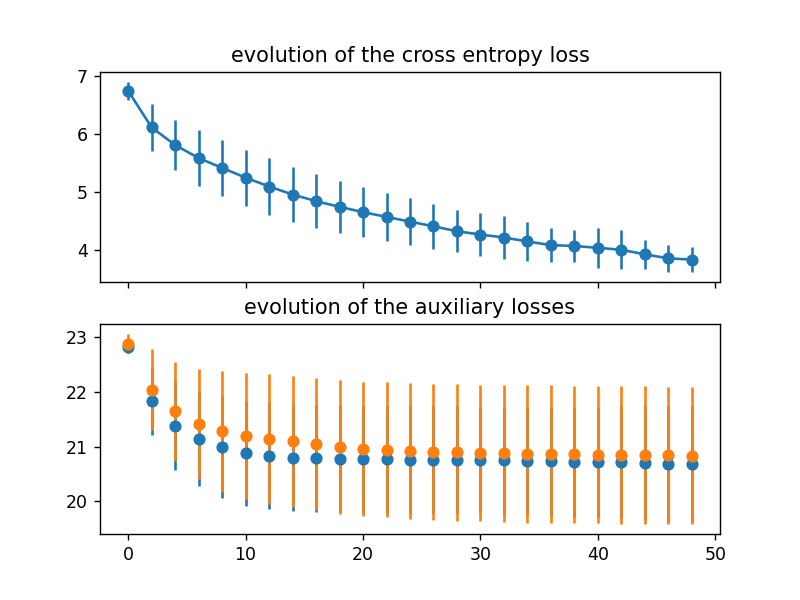

In [46]:
run_many_times(NetGroups3200Aux20)

test error Net 18.30% 183/1000
test error Net 16.70% 167/1000
test error Net 23.80% 238/1000
test error Net 18.00% 180/1000
test error Net 18.50% 185/1000
test error Net 20.90% 209/1000
test error Net 16.20% 162/1000
test error Net 18.30% 183/1000
test error Net 18.50% 185/1000
test error Net 22.60% 226/1000
Average error: 19.18


<IPython.core.display.Javascript object>


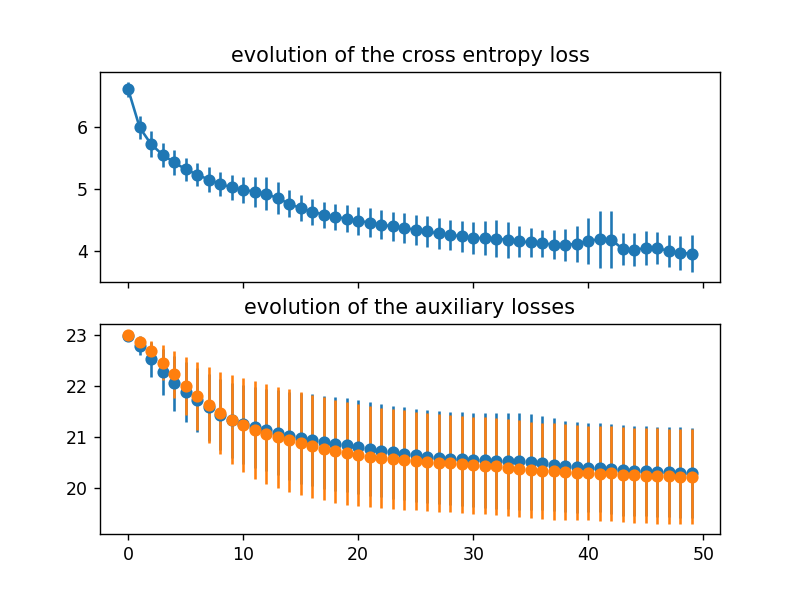

In [23]:
#Same as before but with 20x20 linear layer before the auxiliary loss
run_many_times(NetGroups3200Aux20_20)

test error Net 22.30% 223/1000
test error Net 16.60% 166/1000
test error Net 21.30% 213/1000
test error Net 19.70% 197/1000
test error Net 18.70% 187/1000
test error Net 18.10% 181/1000
test error Net 17.80% 178/1000
test error Net 19.10% 191/1000
test error Net 19.40% 194/1000
test error Net 18.70% 187/1000
Average error: 19.17


<IPython.core.display.Javascript object>


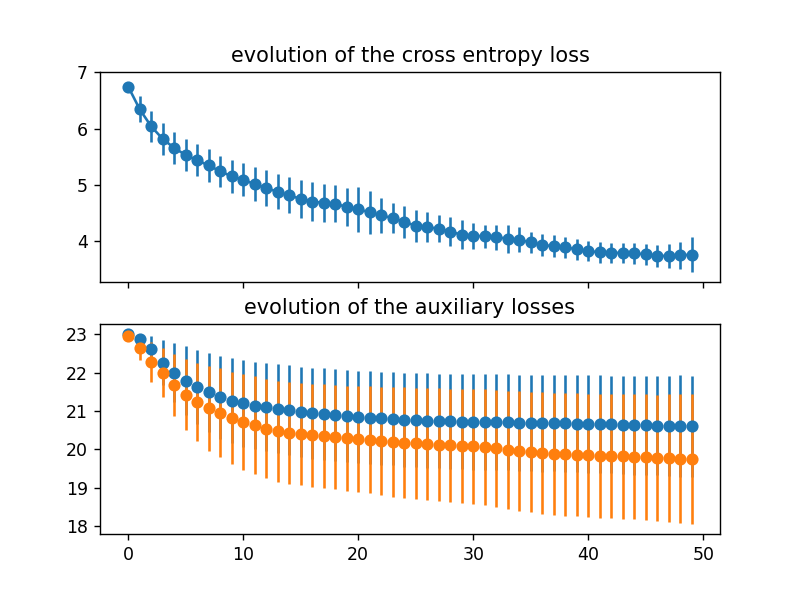

In [24]:
#Same as the first but with 2 linear layers
run_many_times(NetGroups640_160Aux20)

test error Net 19.10% 191/1000
test error Net 19.30% 193/1000
test error Net 21.40% 214/1000
test error Net 22.00% 220/1000
test error Net 19.80% 198/1000
test error Net 19.20% 192/1000
test error Net 22.40% 224/1000
test error Net 21.30% 213/1000
test error Net 29.40% 294/1000
test error Net 18.40% 184/1000
Average error: 21.230000000000004


<IPython.core.display.Javascript object>


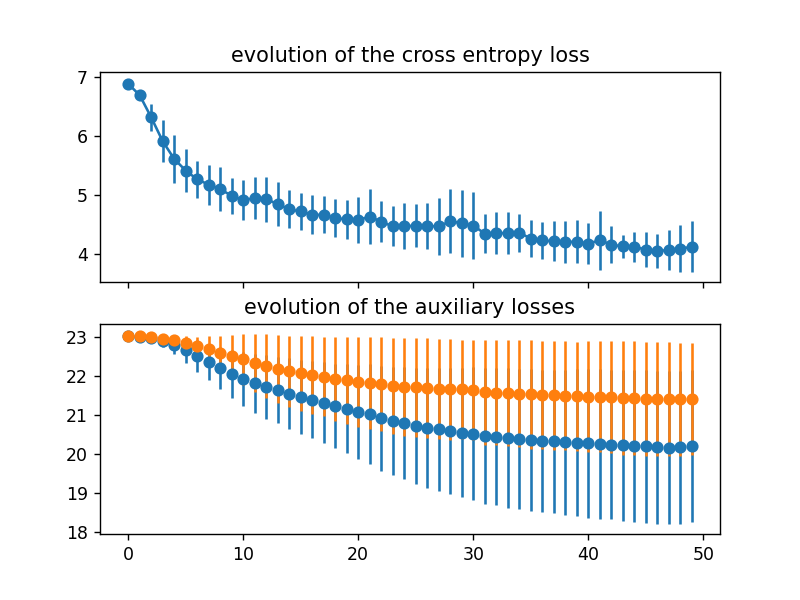

In [25]:
run_many_times(NetGroups320_160_80_40Aux20)

test error Net 16.30% 163/1000
test error Net 16.00% 160/1000
test error Net 20.70% 207/1000
test error Net 17.50% 175/1000
test error Net 18.60% 186/1000
test error Net 18.20% 182/1000
test error Net 16.30% 163/1000
test error Net 16.40% 164/1000
test error Net 16.50% 165/1000
test error Net 18.30% 183/1000
Average error: 17.48


<IPython.core.display.Javascript object>


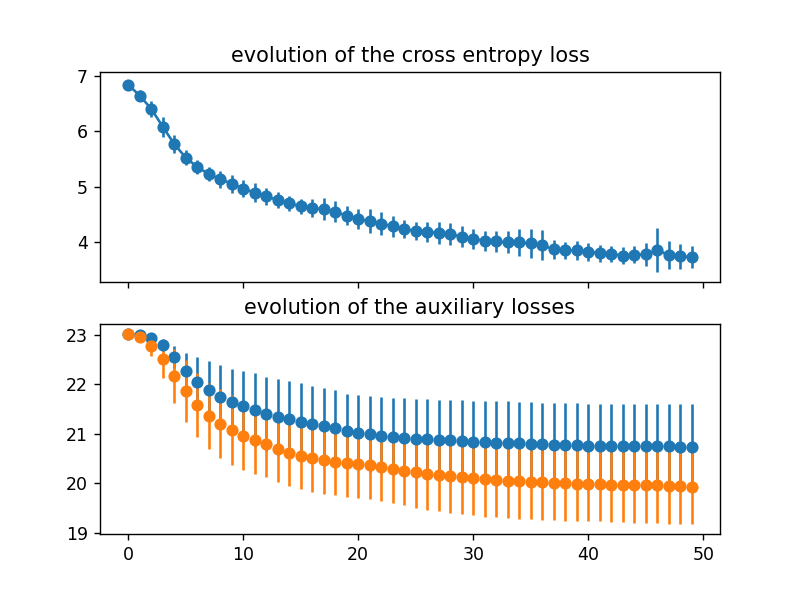

In [26]:
run_many_times(NetGroupsDoubleConvAux20)

test error Net 17.00% 170/1000
test error Net 15.70% 157/1000
test error Net 17.30% 173/1000
test error Net 17.40% 174/1000
test error Net 15.10% 151/1000
test error Net 16.70% 167/1000
test error Net 16.40% 164/1000
test error Net 18.30% 183/1000
test error Net 16.80% 168/1000
test error Net 15.80% 158/1000
Average error: 16.650000000000002


<IPython.core.display.Javascript object>


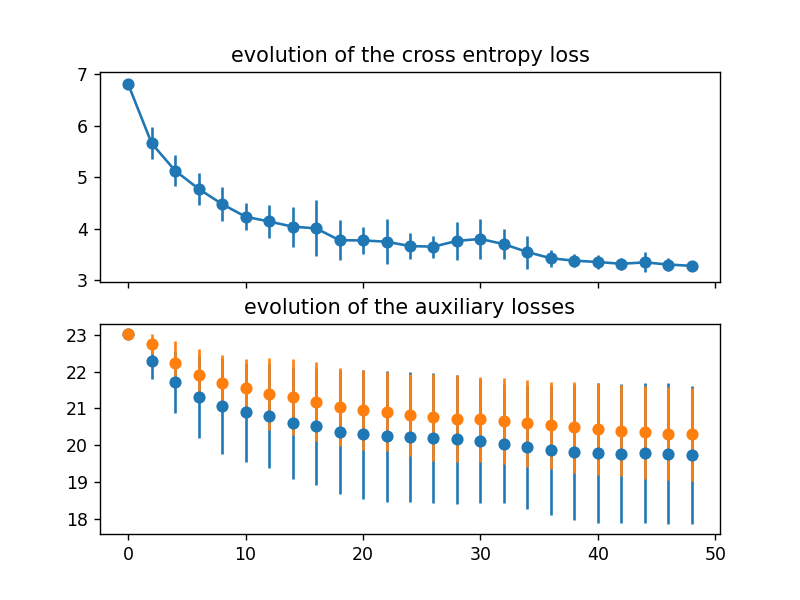

In [6]:
run_many_times(NetGroups320_80DoubleConvAux20)

In [8]:
run_many_times(NetGroups2048TripleConvAux20)

test error Net 16.80% 168/1000
test error Net 18.40% 184/1000
test error Net 18.50% 185/1000
test error Net 17.30% 173/1000
test error Net 18.30% 183/1000
test error Net 17.50% 175/1000
test error Net 17.80% 178/1000
test error Net 17.60% 176/1000
test error Net 17.90% 179/1000
test error Net 18.70% 187/1000
Average error: 17.88


<IPython.core.display.Javascript object>

test error Net 18.80% 188/1000
test error Net 19.40% 194/1000
test error Net 17.00% 170/1000
test error Net 17.80% 178/1000
test error Net 15.90% 159/1000
test error Net 16.30% 163/1000
test error Net 15.90% 159/1000
test error Net 18.50% 185/1000
test error Net 16.40% 164/1000
test error Net 18.10% 181/1000
Average error: 17.410000000000004


<IPython.core.display.Javascript object>


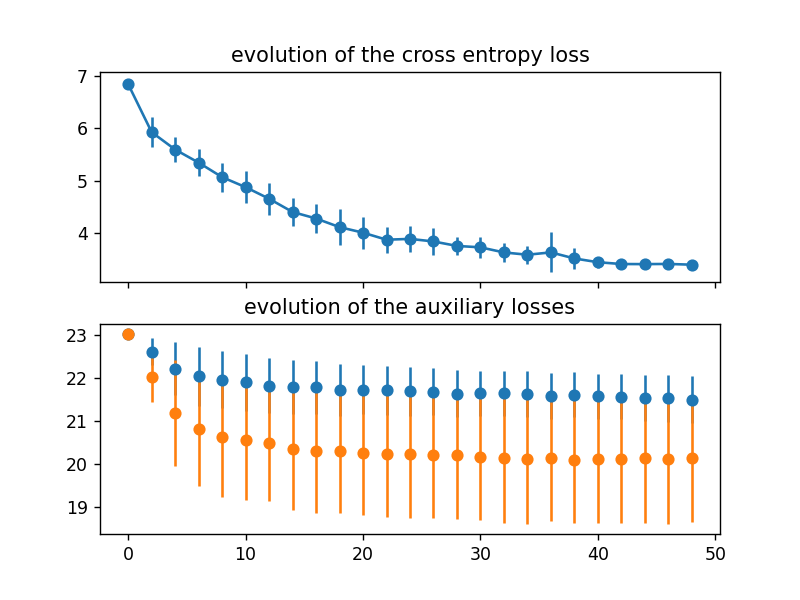

In [11]:
run_many_times(NetGroups2304QuadConvAux20)

test error Net 19.40% 194/1000
test error Net 17.80% 178/1000
test error Net 15.20% 152/1000
test error Net 19.30% 193/1000
test error Net 20.90% 209/1000
test error Net 21.20% 212/1000
test error Net 24.60% 246/1000
test error Net 20.40% 204/1000
test error Net 20.90% 209/1000
test error Net 19.10% 191/1000
Average error: 19.880000000000003


<IPython.core.display.Javascript object>


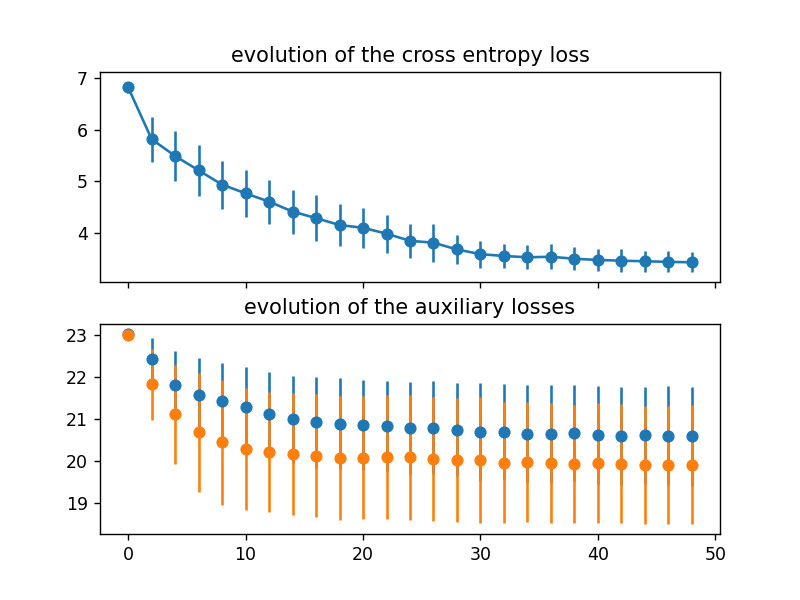

In [12]:
run_many_times(NetGroups2304QuadConvAux20_bis)